In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ExifTags
import cv2 as cv

import time
from time import strftime, localtime
from google.colab import drive
import os
import glob
from datetime import datetime

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Get filenames for all image and mask files.

In [ ]:
healthy_image_files = glob.glob("/content/drive/MyDrive/tree_segmentation/original/healthy/image/*")
sick_image_files = glob.glob("/content/drive/MyDrive/tree_segmentation/original/sick/image/*")
healthy_mask_files = glob.glob("/content/drive/MyDrive/tree_segmentation/original/healthy/mask/*")
sick_mask_files = glob.glob("/content/drive/MyDrive/tree_segmentation/original/sick/mask/*")

Show distribution of input and mask files.

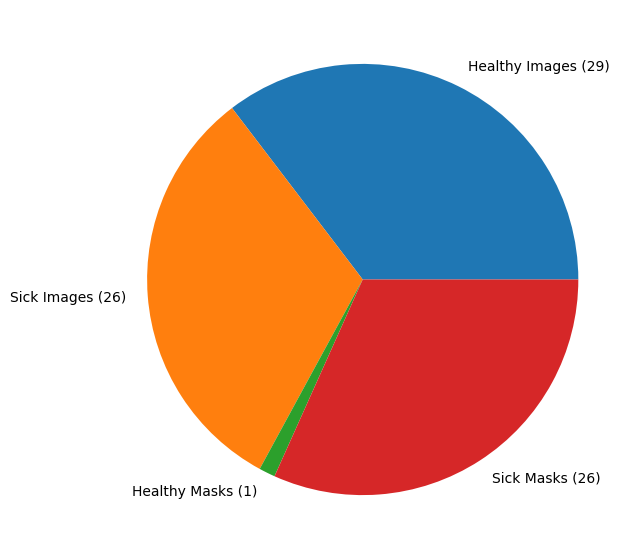

In [ ]:
data = [len(healthy_image_files), len(sick_image_files), len(healthy_mask_files), len(sick_mask_files)]
images_cats = [f"Healthy Images ({data[0]})", f"Sick Images ({data[1]})", f"Healthy Masks ({data[2]})", f"Sick Masks ({data[3]})"]

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = images_cats)

# show plot
plt.show()

Collect and display some metadata for the files in the dataset.

In [ ]:
def get_meta_data(img:Image) -> dict:
  return {ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS}

def get_epoch(td:str, pat:str='%Y:%m:%d %H:%M:%S') -> int:
  return int((datetime.strptime(td, pat) - datetime(1970, 1, 1)).total_seconds())

col_names = ['name', 'size', 'created_epoch', 'label']
image_info = []
for sick, healthy in zip(sick_image_files, healthy_image_files):
  row = [os.path.split(sick)[1], os.path.getsize(sick)/2**20]
  # print(os.path.splitext(sick)[1][1:])
  with Image.open(sick) as img:
    md = get_meta_data(img)
  row.append(get_epoch(md["DateTimeOriginal"]))
  row.append('sick')
  image_info.append(row)

  row = [os.path.split(healthy)[1], os.path.getsize(healthy)/2**20]
  with Image.open(healthy) as img:
    md = get_meta_data(img)
  row.append(get_epoch(md["DateTimeOriginal"]))
  row.append('healthy')
  image_info.append(row)

df = pd.DataFrame(image_info, columns=col_names)
print(f"Number of observations: {len(df['name'])}")
print(f"Max file size: {np.max(df['size']):.2f} MB")
print(f"Min file size: {np.min(df['size']):.2f} MB")
print(f"Mean file size: {np.mean(df['size']):.2f} MB")
first = strftime('%Y-%m-%d %H:%M:%S', localtime(np.min(df['created_epoch'])))
last = strftime('%Y-%m-%d %H:%M:%S', localtime(np.max(df['created_epoch'])))
print(f"Time period covered: {first} to {last} ")

Number of observations: 52
Max file size: 4.18 MB
Min file size: 3.81 MB
Mean file size: 3.97 MB
Time period covered: 2022-09-04 17:45:44 to 2022-09-18 14:32:07 


Display several interesting sick tree images and their corresponding mask files.

<Figure size 640x480 with 0 Axes>

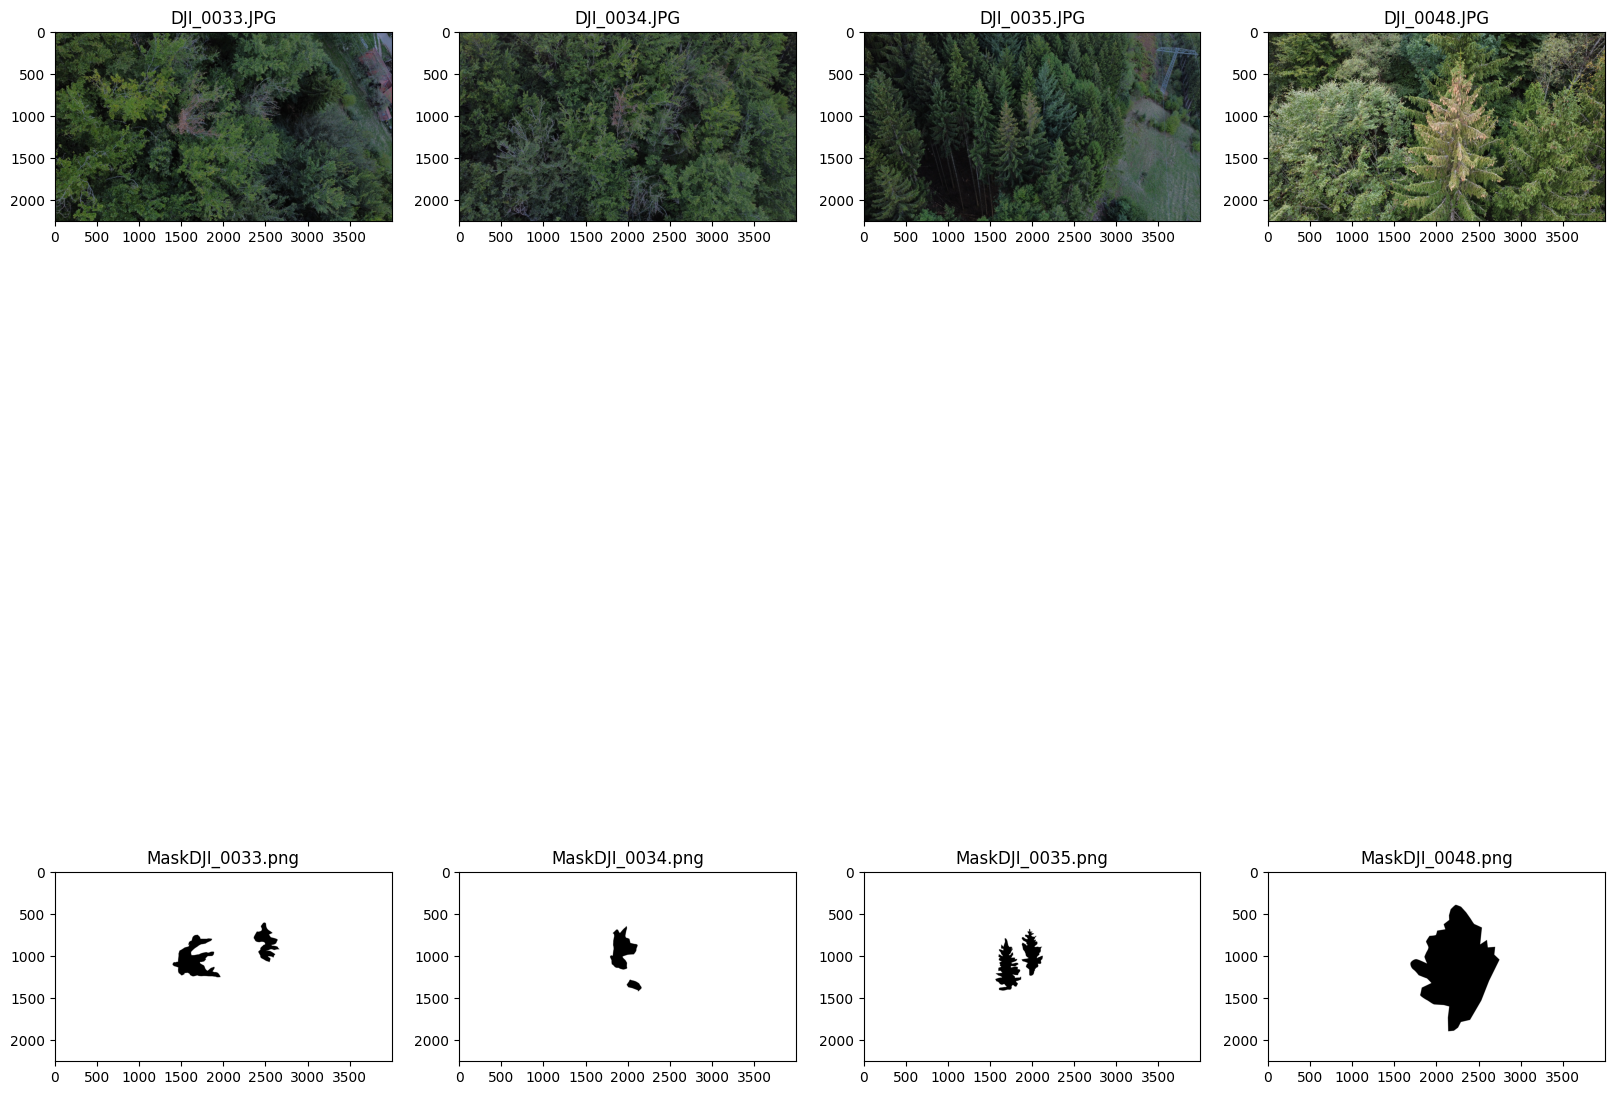

In [ ]:
interesting_sick_images = [
    "DJI_0033",
    "DJI_0034",
    "DJI_0035",
    "DJI_0048",
]
plt.figure()
col_count = len(interesting_sick_images)
f, axrr = plt.subplots(2,col_count,figsize=(20, 20))

idx = 0
for i in interesting_sick_images:
  image_path = f"/content/drive/MyDrive/tree_segmentation/original/sick/image/{i}.JPG"
  with cbook.get_sample_data(image_path) as image_file:
    image = plt.imread(image_file)
  mask_path = f"/content/drive/MyDrive/tree_segmentation/original/sick/mask/Mask{i}.png"
  with cbook.get_sample_data(mask_path) as image_file:
    mask = plt.imread(mask_path)
  axrr[0][idx].imshow(image)
  axrr[0][idx].title.set_text(f"{i}.JPG")
  axrr[1][idx].imshow(mask)
  axrr[1][idx].title.set_text(f"Mask{i}.png")
  idx += 1

Display the normalized RGB histogram for healthy tree images.

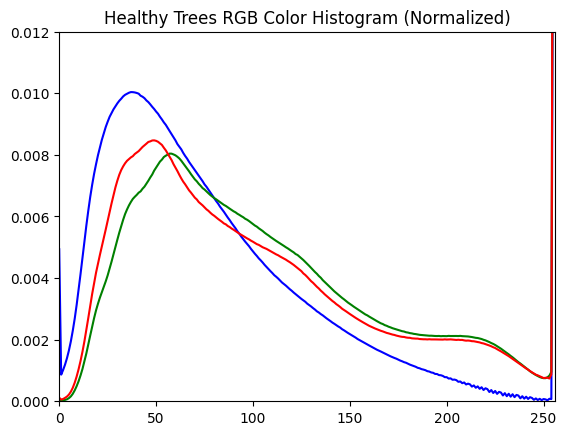

In [ ]:
healthy_image_files.sort()
healthy_mask_files.sort()

imag_list = []
for i in healthy_image_files:
  imag_list.append(cv.imread(i))

color = ('b','g','r')
for i,col in enumerate(color):
  histr =0
  for image in imag_list:
    histr += cv.calcHist([image],[i],None,[256],[0,256])
  plt.plot(histr/len(healthy_image_files)/4000/2250,color = col)
  plt.xlim([0,256])
  plt.ylim([0, .012])
plt.title("Healthy Trees RGB Color Histogram (Normalized)")
plt.show()

Display the normalized RGB histogram for sick tree images.

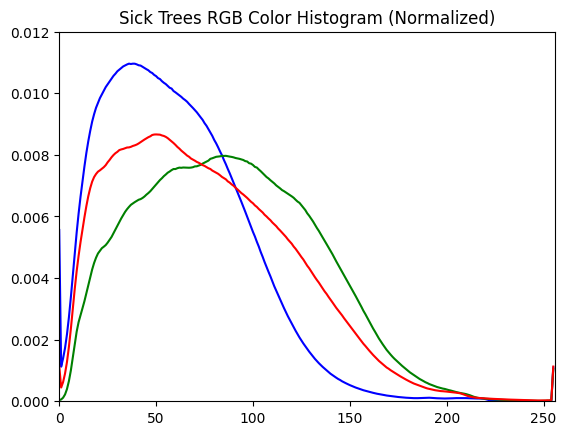

In [ ]:
sick_image_files.sort()
sick_mask_files.sort()

imag_list = []
for i in sick_image_files:
  imag_list.append(cv.imread(i))

color = ('b','g','r')
for i,col in enumerate(color):
  histr =0
  for image in imag_list:
    histr += cv.calcHist([image],[i],None,[256],[0,256])
  histr
  plt.plot(histr/len(sick_image_files)/4000/2250,color = col)
  plt.xlim([0,256])
  plt.ylim([0, .012])
plt.title("Sick Trees RGB Color Histogram (Normalized)")
plt.show()

Display the normalized RGB histogram for healthy tree images with the respective masks applied.

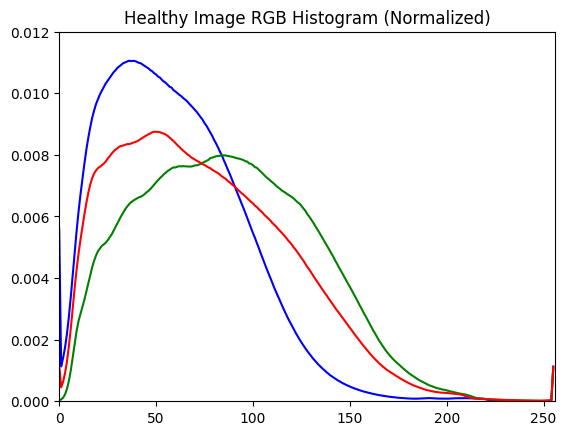

In [ ]:
imag_list = []
mask_list = []

total_healthy_pixels = 0
for (i,m) in zip(sick_image_files,sick_mask_files):
  imag_list.append(cv.imread(i))
  mask = cv.imread(m,0)
  total_healthy_pixels += np.sum(mask==255)
  mask_list.append(mask)

color = ('b','g','r')

for i,col in enumerate(color):
  histr=0
  for image,mask in zip(imag_list,mask_list):
    histr += cv.calcHist([image],[i],mask,[256],[0,256])
  plt.plot(histr/total_healthy_pixels,color = col)
  plt.xlim([0,256])
  plt.ylim([0, .012])
plt.title('Healthy Image RGB Histogram (Normalized)')
plt.show()

Display the normalized RGB histogram for sick tree images with the respective inverted masks applied.

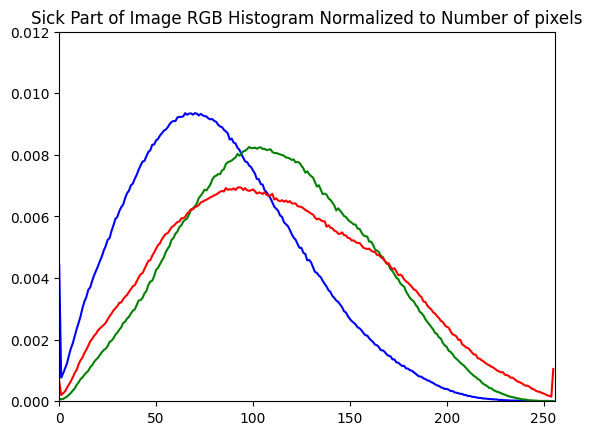

In [ ]:
imag_list = []
mask_list = []

total_sick_pixels = 0
for (i,m) in zip(sick_image_files,sick_mask_files):
  imag_list.append(cv.imread(i))
  inv_mask = cv.bitwise_not(cv.imread(m,0))
  total_sick_pixels += np.sum(inv_mask==255)
  mask_list.append(inv_mask)

color = ('b','g','r')

for i,col in enumerate(color):
  histr=0
  for image,inv_mask in zip(imag_list,mask_list):
    histr += cv.calcHist([image],[i],inv_mask,[256],[0,256])
  plt.plot(histr/total_sick_pixels,color = col)
  plt.xlim([0,256])
  plt.ylim([0, .012])
plt.title('Sick Part of Image RGB Histogram Normalized to Number of pixels')
plt.show()

Display distribution of sick and healthy labeled pixels in dataset.

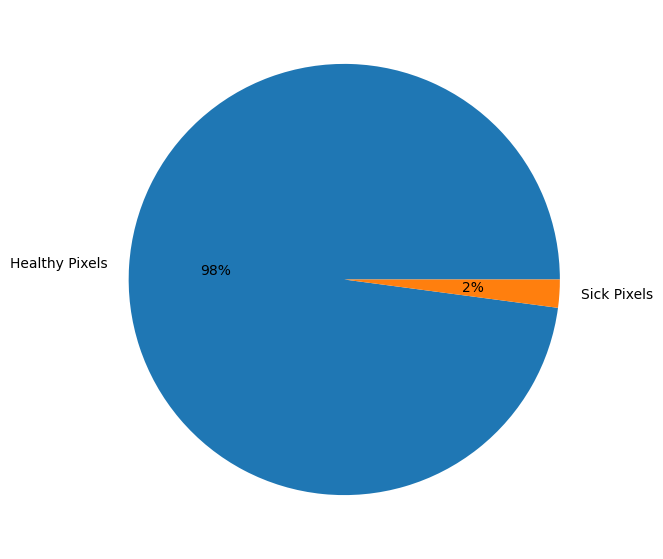

In [ ]:
data = [total_healthy_pixels, total_sick_pixels]
images_cats = [f"Healthy Pixels", f"Sick Pixels"]

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = images_cats,autopct='%1.0f%%')

# show plot
plt.show()

Calculate the correlation metric comparing the masked image to the inverted-masked image.

In [ ]:
def compare_masks(image_file, mask_file):
  img = cv.imread(image_file)
  mask = cv.imread(mask_file,0)
  inv_mask = cv.bitwise_not(mask)

  # Calculate the histograms, and normalize them
  hist_img1 = cv.calcHist([img], [0, 1, 2], mask, [256, 256, 256], [0, 256, 0, 256, 0, 256])
  cv.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
  hist_img2 = cv.calcHist([img], [0, 1, 2], inv_mask, [256, 256, 256], [0, 256, 0, 256, 0, 256])
  cv.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

  # Find the metric value
  return cv.compareHist(hist_img1, hist_img2, cv.HISTCMP_CORREL)

x = []
y = []
for image, mask in zip(sick_image_files, sick_mask_files, strict=True):
  iname = os.path.split(image)[-1]
  metric = compare_masks(image, mask)
  print(f"{iname} :", metric)
  x.append(metric)
  y.append(iname)

DJI_0031.JPG : 0.28041648870095465
DJI_0032.JPG : 0.021281141878413092
DJI_0033.JPG : 0.3889976484014068
DJI_0034.JPG : 0.47459145825604615
DJI_0035.JPG : 0.15649157564329796
DJI_0036.JPG : 0.19366140955602823
DJI_0037.JPG : 0.07354068403359232
DJI_0044.JPG : -0.05564427698298452
DJI_0045.JPG : -0.123232038867442
DJI_0046.JPG : -0.3431289783717754
DJI_0047.JPG : 0.04990298386619227
DJI_0048.JPG : -0.7327755405874625
DJI_0049.JPG : -0.7697459756857618
DJI_0050.JPG : -0.7067167668328671
DJI_0051.JPG : -0.20188187950021422
DJI_0052.JPG : -0.20819573452723386
DJI_0053.JPG : -0.27675675657968796
DJI_0054.JPG : -0.2915721441171885
DJI_0055.JPG : -0.39391844717870633
DJI_0056.JPG : -0.2676410951065035
DJI_0057.JPG : -0.23616448452527705
DJI_0058.JPG : -0.23799949494801542
DJI_0059.JPG : -0.2854415070915064
DJI_0060.JPG : -0.20508999179712079
DJI_0061.JPG : -0.16756707486204658
DJI_0062.JPG : -0.10596591414007094


Plot the calculated correlation metrics.

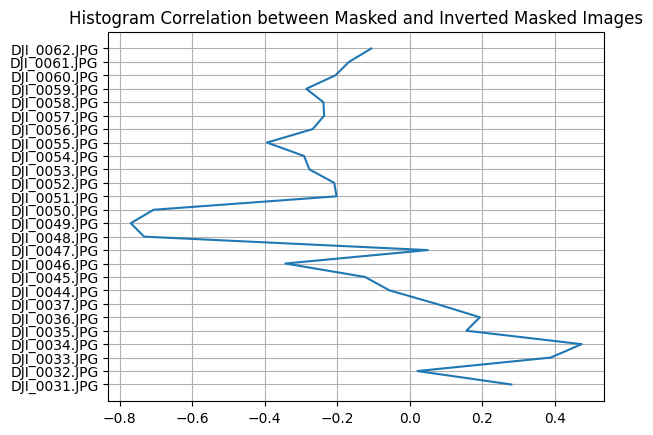

In [ ]:
plt.plot(x,y)
# plt.title('Masked Image to Inverted-Mask Image Histogram Comparison')
plt.grid()
plt.title('Histogram Correlation between Masked and Inverted Masked Images')
plt.show()

Display the comparison of sick tree image histograms (grayscale).

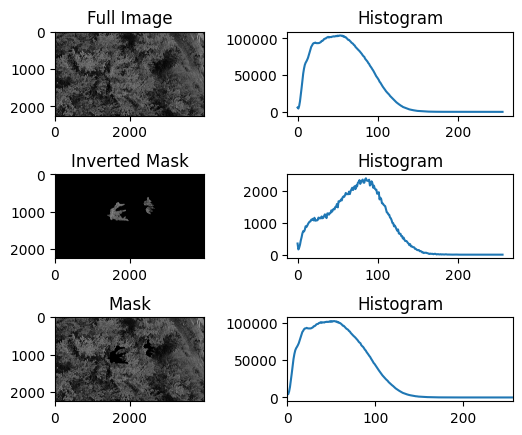

In [ ]:
img_name = "DJI_0033"
img = cv.imread(f"/content/drive/MyDrive/tree_segmentation/original/sick/image/{img_name}.JPG", cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
# create a mask
mask = cv.imread(f"/content/drive/MyDrive/tree_segmentation/original/sick/mask/Mask{img_name}.png", cv.IMREAD_GRAYSCALE)
inv_mask = cv.bitwise_not(mask)
masked_img = cv.bitwise_and(img,img,mask = mask)
inv_masked_img = cv.bitwise_and(img,img,mask = inv_mask)
# Calculate histogram with mask and without mask
hist_full = cv.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv.calcHist([img],[0],mask,[256],[0,256])
hist_inv_mask = cv.calcHist([img],[0],inv_mask,[256],[0,256])
plt.subplots_adjust(hspace=.7)
plt.subplot(321), plt.imshow(img, 'gray'), plt.title("Full Image")
plt.subplot(322), plt.plot(hist_full), plt.title("Histogram")
plt.subplot(323), plt.imshow(inv_masked_img, 'gray'), plt.title("Inverted Mask")
plt.subplot(324), plt.plot(hist_inv_mask), plt.title("Histogram")
plt.subplot(325), plt.imshow(masked_img, 'gray'), plt.title("Mask")
plt.subplot(326), plt.plot(hist_mask), plt.title("Histogram")
plt.xlim([0,256])
plt.show()

Display the comparison of sick tree image histograms (separate RGB channels).

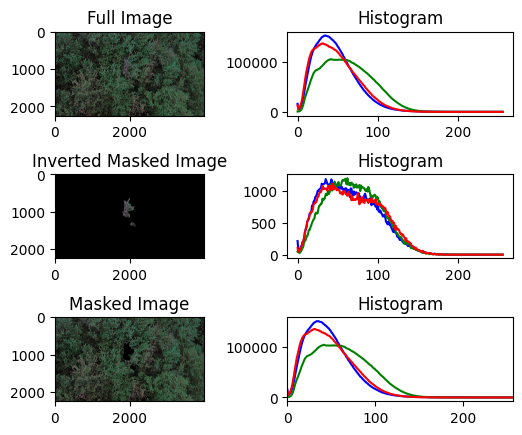

In [ ]:
img_name = "DJI_0034"
img = cv.imread(f"/content/drive/MyDrive/tree_segmentation/original/sick/image/{img_name}.JPG")
assert img is not None, "file could not be read, check with os.path.exists()"
# create a mask
mask = cv.imread(f"/content/drive/MyDrive/tree_segmentation/original/sick/mask/Mask{img_name}.png",0)
inv_mask = cv.bitwise_not(mask)
masked_img = cv.bitwise_and(img,img,mask = mask)
inv_masked_img = cv.bitwise_and(img,img, mask = inv_mask)
# Calculate histogram with mask and without mask
hist_full_b, hist_full_g, hist_full_r = cv.calcHist([img],[0],None,[256],[0,256]), cv.calcHist([img],[1],None,[256],[0,256]), cv.calcHist([img],[2],None,[256],[0,256])
hist_mask_b, hist_mask_g, hist_mask_r = cv.calcHist([img],[0],mask,[256],[0,256]), cv.calcHist([img],[1],mask,[256],[0,256]), cv.calcHist([img],[2],mask,[256],[0,256])
hist_inv_mask_b, hist_inv_mask_g, hist_inv_mask_r = cv.calcHist([img],[0],inv_mask,[256],[0,256]), cv.calcHist([img],[1],inv_mask,[256],[0,256]), cv.calcHist([img],[2],inv_mask,[256],[0,256])
plt.subplots_adjust(hspace=.7)
plt.subplot(321), plt.imshow(img), plt.title("Full Image")
plt.subplot(322), plt.plot(hist_full_b, color = 'b'), plt.plot(hist_full_g, color = 'g'), plt.plot(hist_full_r, color = 'r'), plt.title("Histogram")
plt.subplot(323), plt.imshow(inv_masked_img), plt.title("Inverted Masked Image")
plt.subplot(324), plt.plot(hist_inv_mask_b, color = 'b'), plt.plot(hist_inv_mask_g, color = 'g'), plt.plot(hist_inv_mask_r, color = 'r'), plt.title("Histogram")
plt.subplot(325), plt.imshow(masked_img), plt.title("Masked Image")
plt.subplot(326), plt.plot(hist_mask_b, color = 'b'), plt.plot(hist_mask_g, color = 'g'), plt.plot(hist_mask_r, color = 'r'), plt.title("Histogram")
plt.xlim([0,256])
plt.show()

Display the comparison of healthy tree image histograms (grayscale).

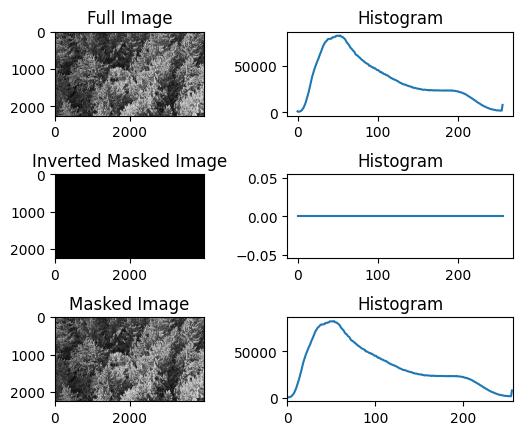

In [ ]:
img_name = "DJI_0077"
img = cv.imread(f"/content/drive/MyDrive/tree_segmentation/original/healthy/image/{img_name}.JPG", cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
# create a mask
mask = cv.imread("/content/drive/MyDrive/tree_segmentation/original/healthy/mask/OnlyHealthyMask.png", cv.IMREAD_GRAYSCALE)
inv_mask = cv.bitwise_not(mask)
masked_img = cv.bitwise_and(img,img,mask = mask)
inv_masked_img = cv.bitwise_and(img,img,mask = inv_mask)
# Calculate histogram with mask and without mask
hist_full = cv.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv.calcHist([img],[0],mask,[256],[0,256])
hist_inv_mask = cv.calcHist([img],[0],inv_mask,[256],[0,256])
plt.subplots_adjust(hspace=.7)
plt.subplot(321), plt.imshow(img, 'gray'), plt.title("Full Image")
plt.subplot(322), plt.plot(hist_full), plt.title("Histogram")
plt.subplot(323), plt.imshow(inv_masked_img, 'gray'), plt.title("Inverted Masked Image")
plt.subplot(324), plt.plot(hist_inv_mask), plt.title("Histogram")
plt.subplot(325), plt.imshow(masked_img, 'gray'), plt.title("Masked Image")
plt.subplot(326), plt.plot(hist_mask), plt.title("Histogram")
plt.xlim([0,256])
plt.show()

Display the normalized histograms of several selected similar images (grayscale).

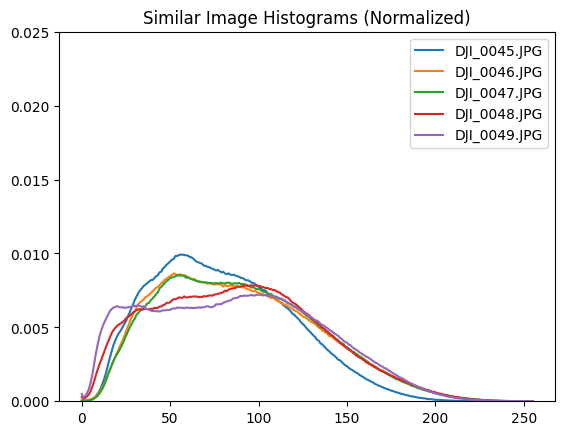

In [ ]:
images = ["DJI_0045", "DJI_0046", "DJI_0047", "DJI_0048", "DJI_0049"]

fig, ax = plt.subplots(1,1)
for image in images:
  img = cv.imread(f"/content/drive/MyDrive/tree_segmentation/original/sick/image/{image}.JPG", cv.IMREAD_GRAYSCALE)
  assert img is not None, "file could not be read, check with os.path.exists()"
  h = cv.calcHist([img],[0],None,[256],[0,256])
  ax.plot(h/(4000*2250), label=f"{image}.JPG")
plt.ylim([0, .025])
plt.title('Similar Image Histograms (Normalized)')
plt.legend()
plt.show()

Display the normalized histograms of several selected dissimilar images (grayscale).

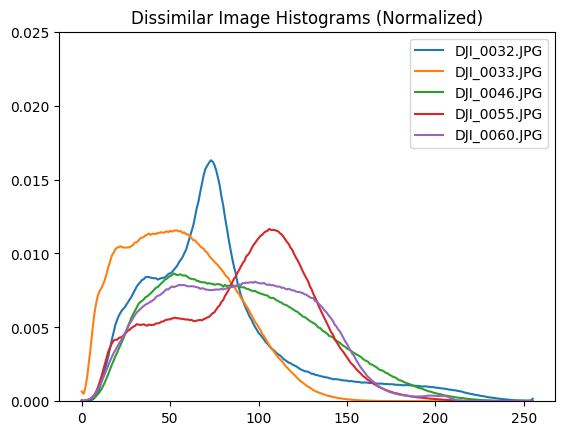

In [ ]:
images = ["DJI_0032","DJI_0033", "DJI_0046", "DJI_0055", "DJI_0060"]

fig, ax = plt.subplots(1,1)
for image in images:
  img = cv.imread(f"/content/drive/MyDrive/tree_segmentation/original/sick/image/{image}.JPG", cv.IMREAD_GRAYSCALE)
  assert img is not None, "file could not be read, check with os.path.exists()"
  h = cv.calcHist([img],[0],None,[256],[0,256])
  ax.plot(h/(4000*2250), label=f"{image}.JPG")
plt.ylim([0, .025])
plt.title('Dissimilar Image Histograms (Normalized)')
plt.legend()
plt.show()